# Scraping Airbnb by Scraping Fish

This notebook is an example of how you can scrape a website which uses JavaScript to render its content by using [Scraping Fish API](https://scrapingfish.com). We will extract Airbnb's offers data and perform some basic data visualization. It accompanies [the blog post](https://scrapingfish.com/blog/scraping-airbnb) which explains everything in more detailed manner.

To be able to run this notebook and actually scrape the data, you will need Scraping Fish API key which you can [buy here](https://scrapingfish.com/buy). A starter pack costing just $2 will be more than enough to run the notebook many times. Without it, JavaScript will not be rendered and therefore no content will be available on Airbnb's website. 

Scraping Fish is an API for scraping powered by rotating 4G/LTE mobile proxy by default. It is the best available proxy type for scraping since mobile IPs are ephemeral and constantly reassigned between real users. This type of proxy is capable of scraping even the most demanding websites, without being blocked. You can read more on advanced topics in Scraping Fish API [Documentation](https://scrapingfish.com/docs/intro).

## Imports
Required packages imported in the cell below are listed in requirements.txt file. Install them first by running `pip install -r requirements.txt`.

In [ ]:
import requests
import pandas as pd
import datetime
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.parse import quote_plus
from tqdm import tqdm
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.set(font_scale=1.3)

## API key
Scraping Fish API key is needed to run this example as it allows rendering JS during scraping easily. The API integration only requires adding the prefix to all scraped urls.

You can [get API key](https://scrapingfish.com/buy) by buying the cheapest request pack for $2.

In [2]:
API_KEY = "[Your Scraping Fish API key]"
url_prefix = f"https://scraping.narf.ai/api/v1/?render_js=true&api_key={API_KEY}&url="

## Parameters
Here we define parameters of our query. In this example we scrape San Francisco Bay Area offers available between 2022/06/01 and 2022/10/14, sampling every 45th day. You can change these parameters to whatever you prefer but keep in mind that changing the frequency to lower values (e.g. `"1D"`) will result in much longer scraping and not necessarily much better results.

In [3]:
query = "San-Francisco-Bay-Area--CA--United-States"
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 10, 14)
freq = '45D'
num_guests = 1

## Scraping and Parsing
For a given query Airbnb lists 300 offers (15 pages, 20 offers per page). We will scrape all those 15 pages per each processed day and extract info from each offer and append those to a collection.

### Parsing individual offer
First, let's define a function responsible for parsing an individual offer. It will be called for each offer in a page to extract the relevant info to a dictionary which will then be appended to the collection of all offers. We also need to define a mapping to standardize plular and singular forms to a common one.

BeatufiulSoup is used here to select subelements from the top offer's element.

In [ ]:
key_map = {
    'bathrooms': 'bathrooms',
    'bathroom': 'bathrooms',
    'baths': 'bathrooms',
    'bath': 'bathrooms',
    'shared baths': 'bathrooms',                    
    'shared bath': 'bathrooms',
    'private baths': 'bathrooms',                    
    'private bath': 'bathrooms',
    'half-bath': 'bathrooms',
    'bedrooms': 'bedrooms',
    'bedroom': 'bedrooms',
    'private bedrooms': 'bedrooms',
    'private bedroom': 'bedrooms',                    
    'beds': 'beds',
    'bed': 'beds',
    'guest': 'capacity',
    'guests': 'capacity',
}

def parse_offer(offer, checkin):
    offer_id = offer.select("a")[0]['target'].split("listing_")[-1]
    offer_price = float(''.join(offer.select("span._tyxjp1")[0].text.replace(",", "").split("$")[1:]))
    offer_type = offer.select("div.mj1p6c8")[0].text.split(" in")[0]
    offer_features = [feature.text for feature in offer.select("span.mp2hv9t")]
            
    current_offer = {
        "id": offer_id,
        "price": offer_price,
        "checkin": checkin,
        "type": offer_type,
    }
    feature_sets = offer.select("div.i1wgresd")
    basic_features = [t.text.lower() for t in feature_sets[0].select("span.mp2hv9t")]
    other_features = [t.text.lower() for t in feature_sets[1].select("span.mp2hv9t")] if len(feature_sets) > 1 else []
    skip = False
    for feature in basic_features:
        split = feature.split()
        if len(split) > 1:
            key = ' '.join(split[1:])
            if key == 'room types':
                return None
            current_offer[key_map[key]] = split[0]
        else:
            if split[0].lower() == 'studio':
                current_offer['bedrooms'] = 0

    current_offer['wi-fi'] = 'wifi' in other_features
    current_offer['kitchen'] = 'kitchen' in other_features
    current_offer['washer'] = 'washer' in other_features
    current_offer['free parking'] = 'free parking' in other_features
    return current_offer

### Date processing
For each date in the given date range we process it by querying all the 15 pages of results. For each page, we extract all elements containing offer information, parse it (using the `parse_offer` function defined above) and append the resulting dictionary to the `offers` collection.

In [4]:
def process_date(checkin_date, num_guests=1):
    checkin = checkin_date.strftime("%Y-%m-%d")
    checkout = (checkin_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    
    offers = []
    total_num_pages = 15
    page = 1
    end = False
    while page <= total_num_pages:
        items_offset = (page - 1) * 20
        url = f"https://www.airbnb.com/s/{query}/homes?checkin={checkin}&checkout={checkout}&adults={num_guests}&items_offset={items_offset}&display_currency=USD"
        url = quote_plus(url)
        response = requests.get(f"{url_prefix}{url}")
        soup = BeautifulSoup(response.content, "html.parser")
        try:
            offers_divs = soup.select("div.cm4lcvy")
            for offer in offers_divs:
                print(offer)
                current_offer = parse_offer(offer, checkin)
                if current_offer != None:
                    offers.append(current_offer)

        
            page += 1
        except Exception as e:
            with open(f"{items_offset}.html", "wb") as f:
                f.write(response.content)
            raise e
    return offers

### Scraping process
Now we just iterate over the desired date range and process each date according to the logic defined in functions above. It will take a couple of minutes depending on the range. 

In [14]:
offers = []
for date in tqdm(pd.date_range(start_date, end_date, freq=freq)):
    offers += process_date(checkin_date=date)

  0%|                                                                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

2022-06-01 00:00:00


  0%|                                                                                                                                                                                                                   | 0/4 [00:36<?, ?it/s]


In [12]:
offers

[]

## Data exploration

Now that we have the data ready in memory, let's create a pandas dataframe and explore it. We will also write our data to csv and load it which has an additional benefit of auto-conversion of numeric data to proper types.

In [6]:
offers_df = pd.DataFrame(offers)
offers_df.to_csv('./data.csv', sep=';', index=False)
offers_df = pd.read_csv("./data.csv", sep=";")

We will clear duplicated ads first, count the data and count values by type.

In [7]:
offers_df = offers_df.drop_duplicates(subset=['id'], keep='last')
print("Number of data points:", len(offers_df))
print(offers_df['type'].value_counts())

Number of data points: 677
Private room                 241
Entire home                  104
Entire guest suite            96
Entire guesthouse             75
Entire rental unit            43
Room                          20
Entire cottage                14
Hotel room                    13
Entire condo                   8
Entire cabin                   7
Tiny home                      6
Entire bungalow                6
Entire apartment               5
Hostel beds                    5
Hostel room                    4
Entire vacation home           4
Treehouse                      4
Farm stay                      3
Tent                           3
Shared room                    2
Entire villa                   2
Boat                           2
Houseboat                      2
Yurt                           2
Entire serviced apartment      1
Entire loft                    1
Tower                          1
Camper/RV                      1
Entire townhouse               1
Bus             

Here we see a fair count of detailed types but we are more insterested in broader type, i.e. we want only to count: "Entire place", "Private room", "Hotel room" and "Shared room":

In [10]:
offers_df["type"].replace({
    "Entire home": "Entire place",
    "Entire guest suite": "Entire place",
    "Entire guesthouse": "Entire place",
    "Entire rental unit": "Entire place",
    "Entire cottage": "Entire place",
    "Entire condo": "Entire place",
    "Entire cabin": "Entire place",
    "Entire bungalow": "Entire place",
    "Tiny home": "Entire place", 
    "Entire villa": "Entire place",
    "Treehouse": "Entire place",
    "Entire vacation home": "Entire place",
    "Entire apartment": "Entire place",
    "Boat": "Entire place",
    "Houseboat": "Entire place",
    "Farm stay": "Entire place",
    "Tower": "Entire place",
    "Entire loft": "Entire place",
    "Entire townhouse": "Entire place",
    "Bus": "Entire place",
    "Camper/RV": "Entire place",
    "Yurt": "Entire place",
    "Tent": "Entire place",
    "Entire serviced apartment": "Entire place",
    "Room": "Private room",
    "Hostel room": "Private room",
    "Hostel beds": "Shared room",
}, inplace=True)

### What types of offers are the most common? How many beds is expected per type?
Now, let's see how many of those broader types offers are there and at the same type find out how many beds those type typically offer:

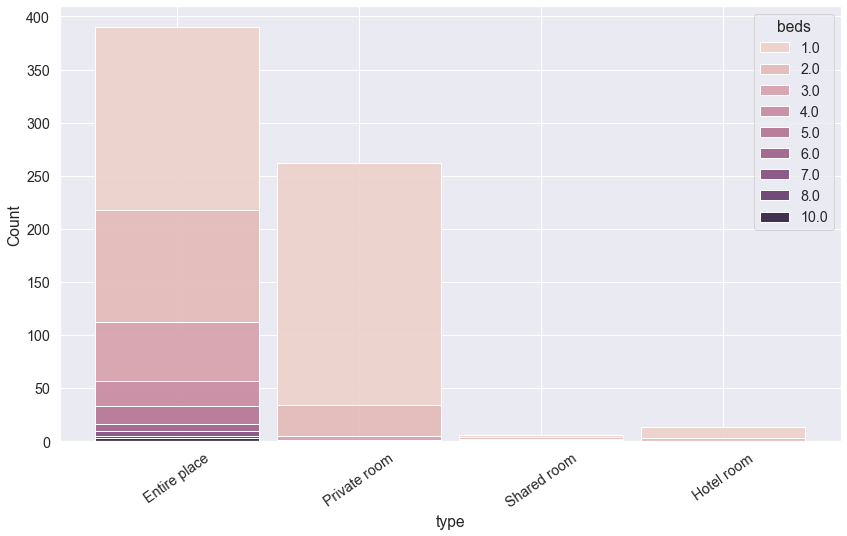

In [11]:
plt.figure(figsize=(14,8))
ax = sns.histplot(data=offers_df, x="type", shrink=0.9, alpha=0.9, multiple="stack", hue="beds")
for label in ax.get_xticklabels():
    label.set_rotation(35)

Whole places clearly dominate the space and most of the places have 1 or 2 beds. Let's now see how prices relate to capacity of the offers:

### Price to max. number of guests and most expensives offers

We will now check how prices relate to guest capacity.

[Text(0.5, 0, 'Max. number of guests'), Text(0, 0.5, 'Price')]

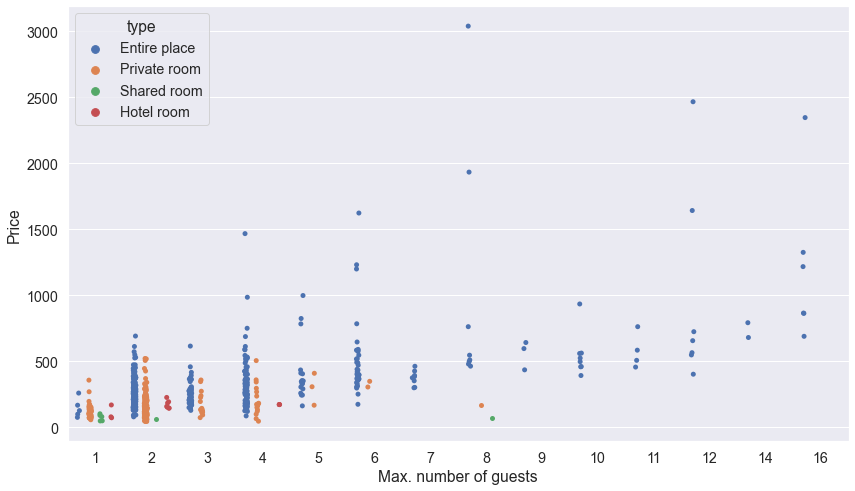

In [12]:
plt.figure(figsize=(14,8))
ax = sns.stripplot(data=offers_df, x="capacity", y="price", dodge=True, hue="type")
ax.set(xlabel="Max. number of guests", ylabel="Price")

### The most expensive offers
Below we get the offers priced over $1,500 and generate links to them.

In [15]:
offers_df[offers_df.price > 1500]

,id,price,checkin,type,capacity,bedrooms,beds,bathrooms,wi-fi,kitchen,washer,free parking
559,33517793,1934.0,2022-07-16,Entire place,8,3,3.0,3,True,True,True,False
745,49156839,1624.0,2022-08-30,Entire place,6,3,4.0,2,True,True,True,True
756,571648129847713657,2347.0,2022-08-30,Entire place,16,5,10.0,4,True,True,True,True
784,19886749,3040.0,2022-08-30,Entire place,8,3,8.0,2,True,True,True,True
871,49929211,1643.0,2022-08-30,Entire place,12,4,6.0,2,True,True,True,True
1167,4033038,2467.0,2022-10-14,Entire place,12,4,5.0,3.5,True,True,True,True


In [18]:
for offer_id in offers_df[offers_df.price > 1500].id:
    print(f"https://airbnb.com/rooms/{offer_id}")

https://airbnb.com/rooms/33517793
https://airbnb.com/rooms/49156839
https://airbnb.com/rooms/571648129847713657
https://airbnb.com/rooms/19886749
https://airbnb.com/rooms/49929211
https://airbnb.com/rooms/4033038


# Wrap up

Airbnb is an example website which doesn't show much content without javascript enabled. Scraping Fish [javascript rendering](https://scrapingfish.com/docs/api-options) feature made dealing with this a breeze.

We barely scratched the surface of what's possible when it comes to data exploration. For the sake of simplicity we restricted our analysis to relatively small dataset. However, we plan to get much more data and conduct a more thorough analysis so stay tuned and check our blog for more!

If you are interested in scraping data and building products around it give Scraping Fish a try. You can [start](https://scrapingfish.com/buy) with only $2 and absolutely no commitment.